In [1]:
#####
# Important note: before running cells pls install the following libraries in your env
# pip install googlemaps(for using Geocoder())
# pip install seaborn (optional plot library)
#
#[checked in by David Lai] pls run pip install googlemaps and pip install seaborn in your env... all cell should run at this version
#Point of interest in this notebook:
#1) Google heatmap using crime activities and coordinates.
#2) Google marker map layer using nearby Police Dept locations 
#Optional/Extra:
#3) Use seaborn to illustrate linear regression relationship between number of PD and crime activities
#4) Use seaborn to illustrate the density estimate between number of PD and crime activities
#
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import traceback
import gmaps
import os

# Import API key
from api_keys import g_key

crime = pd.read_excel("Crime_Data_Sacramento_County.xlsx")
crime

,X,Y,FID,ActivityNumber,District,Neighborhood,OccurenceStartDate,OccurenceEndDate,ReportDate,OccurenceLocation,OccurenceCity,OccurenceZipCode,PrimaryViolation
0,6.765513e+06,1.994405e+06,1,NaN,NaN,Old Fair Oaks,2009-03-26 17:10:00,2009-03-26 17:19:59,2009-03-26 17:39:00,9300 Block of Fair O,Fair Oaks,95628,PC 594(B)(1) Vandalism ($400 Or More)
1,1.517236e-04,-2.607703e-06,2,"]\=""-0092335",North Central,Carmichael Park,2018-03-19 21:30:00,2018-03-19 21:59:59,2018-03-20 17:00:00,5100 Block of Janell,Carmichael,95608,PC 273.5 Inflict Crpl Inj Sp/Cohab
2,6.756477e+06,1.974923e+06,3,03/30-0055028,East,Cordova Meadows,2015-03-06 01:11:00,2015-03-06 01:11:00,2015-03-06 00:00:00,10000 Block of Terra,Rancho Cordova,95670,PC 594(B)(2)(A) Vandalism Less Than $400
3,6.741558e+06,1.960069e+06,4,19-0009846,East,Rosemont Downs,2019-01-09 08:52:59,2019-01-09 09:04:00,2019-01-09 14:19:00,8900 Block of Canberra Dr,Sacramento,95826,PC 459 Burglary
4,6.749211e+06,2.004272e+06,5,1977-0020606,North,Foothill Farms NE,1977-01-01 00:00:00,2001-01-01 00:00:00,2019-08-06 00:00:00,5200 Block of Auburn Blvd,Sacramento,95841,PC 261(A)(1) Rape:Victim Incapable Of Giving C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
362000,1.517236e-04,-2.607703e-06,362001,2020-8002056,NaN,NaN,2018-12-15 02:16:00,2019-09-23 16:18:00,2020-01-28 03:24:59,5100 Block of spyglass drive DR,las vegas nevada,NaN,PC 530.5(B) Using Another Person's Identifying...
362001,1.517236e-04,-2.607703e-06,362002,2020-8002082,NaN,NaN,2019-11-20 01:01:00,2019-11-20 23:58:59,2020-01-10 10:44:00,8300 Block of MEDEIROS WAY,SACRAMENTO,95829,PC 368(D) Theft of Elder
362002,6.755575e+06,2.005506e+06,362003,2020-8002107,North,Mercy San Juan,2020-01-21 03:00:00,2020-01-21 03:14:59,2020-01-21 10:28:00,6100 Block of Marwick Way,Carmichael,95608,PC 487 Theft from vehicle > $950
362003,6.764044e+06,1.997386e+06,362004,2-0282708,Northeast,Old Fair Oaks,2012-12-20 13:57:00,2012-12-20 13:57:00,2012-12-20 13:57:00,7400 Block of Windin,Fair Oaks,95628,PC 459 Burglary


In [2]:
len(crime)

362005

In [3]:
len(crime.dropna())

244242

In [4]:
housing = pd.read_csv("cleaned_housing_data.csv")
housing

,state,counties,city,price,type,beds,baths,sqfeet,latlong
0,ca,sacramento,roseville,1900,apartment,3,2.0,1250,"(38.7724, -121.263)"
1,ca,sacramento,rosemont,1325,apartment,1,1.0,640,"(38.5643, -121.378)"
2,ca,sacramento,florin,2010,apartment,3,2.0,1232,"(38.4249, -121.471)"
3,ca,sacramento,manteca,2699,house,4,3.5,2660,"(37.7661, -121.201)"
4,ca,sacramento,folsom,1450,apartment,1,1.0,700,"(38.6709, -121.153)"
...,...,...,...,...,...,...,...,...,...
2380,ca,sacramento,west sacramento,1625,apartment,1,1.0,735,"(38.4962, -121.53)"
2381,ca,sacramento,rancho cordova,1100,apartment,1,1.0,620,"(38.5934, -121.318)"
2382,ca,sacramento,florin,1300,apartment,2,1.0,808,"(38.4743, -121.445)"
2383,ca,sacramento,lincoln,2595,house,4,3.0,2370,"(38.9025, -121.32)"


In [5]:
len(housing)

2385

In [6]:
housing_master = housing
housing = housing[['city','latlong']]#,'sqfeet','price']]
#cityGroup_df = housing.groupby('city').sum()
housing = housing.drop_duplicates()
housing
#cityGroup_df # around 50 cities in dataset
#final_df = pd.merge()

,city,latlong
0,roseville,"(38.7724, -121.263)"
1,rosemont,"(38.5643, -121.378)"
2,florin,"(38.4249, -121.471)"
3,manteca,"(37.7661, -121.201)"
4,folsom,"(38.6709, -121.153)"
...,...,...
2352,rancho cordova,"(38.5802, -121.274)"
2360,roseville,"(38.7715, -121.34)"
2370,sacramento,"(38.5628, -121.468)"
2374,foothill farms,"(38.672, -121.324)"


In [7]:
crime_master = crime
#crime.dropna(inplace=True)

#print(f"{len(crime.dropna())}")
crime_by_city = crime.dropna().groupby('OccurenceCity').ActivityNumber.count()
crime_by_city = crime_by_city.reset_index()
crime_by_city['OccurenceCity'] = crime_by_city['OccurenceCity'].str.lower()
crime_by_city

,OccurenceCity,ActivityNumber
0,antelope,10668
1,aptos,1
2,carmichael,21852
3,citrus heights,954
4,courtland,121
5,elk grove,2193
6,elverta,937
7,fair oaks,11371
8,folsom,71
9,galt,678


In [8]:
# Please do the following in your terminal before running the below cell
# pip install googlemaps
# googlemaps: library for getting coordinates from a city
# citypy: library for getting city from a set of coordinates
from googlemaps import Client as GoogleMaps
gmapsDecoder = GoogleMaps(g_key)
crime_by_city['Lat'] = ''
crime_by_city['Lng'] = ''

for x in range(len(crime_by_city)):
    geocode_result = gmapsDecoder.geocode(crime_by_city['OccurenceCity'][x])
    crime_by_city['Lat'][x] = geocode_result[0]['geometry']['location'] ['lat']
    crime_by_city['Lng'][x] = geocode_result[0]['geometry']['location']['lng']
crime_by_city.head()

,OccurenceCity,ActivityNumber,Lat,Lng
0,antelope,10668,36.9265,-96.5935
1,aptos,1,36.9772,-121.899
2,carmichael,21852,38.6171,-121.328
3,citrus heights,954,38.7071,-121.281
4,courtland,121,38.3315,-121.57


In [9]:
final_df = pd.merge(crime_by_city,housing,left_on='OccurenceCity',right_on='city', how='left')
final_df = final_df.dropna()
final_df = final_df.drop_duplicates()
final_df.groupby('OccurenceCity').mean()

,ActivityNumber
OccurenceCity,
carmichael,21852
citrus heights,954
elk grove,2193
fair oaks,11371
folsom,71
galt,678
north highlands,14955
orangevale,7547
rancho cordova,30874


In [10]:
# Configure gmaps with API key
gmaps.configure(api_key=g_key)
#final_df = final_df.iloc[2:]
# Store 'Lat' and 'Lng' into  locations 
locations = final_df['latlong'].astype(str)
#locations = final_df.iloc[2:0]

# Convert ActivityNumber to float and store
activityCount = final_df['ActivityNumber'].astype(float)
print(len(locations))
print(len(activityCount))

lat = []
lng = []
for i in locations:
    i = i[1:-1]
    res = tuple(map(str, i.split(', ')))
    lat.append(res[0])
    lng.append(res[1])

final_df['lat'] = lat
final_df['lng'] = lng

final_df

316
316


,OccurenceCity,ActivityNumber,Lat,Lng,city,latlong,lat,lng
2,carmichael,21852,38.6171,-121.328,carmichael,"(38.6269, -121.328)",38.6269,-121.328
3,carmichael,21852,38.6171,-121.328,carmichael,"(38.6097, -121.327)",38.6097,-121.327
4,carmichael,21852,38.6171,-121.328,carmichael,"(38.6174, -121.351)",38.6174,-121.351
5,carmichael,21852,38.6171,-121.328,carmichael,"(38.6229, -121.331)",38.6229,-121.331
6,carmichael,21852,38.6171,-121.328,carmichael,"(38.6239, -121.384)",38.6239,-121.384
...,...,...,...,...,...,...,...,...
326,west sacramento,1,38.5805,-121.53,west sacramento,"(38.4849, -121.535)",38.4849,-121.535
327,west sacramento,1,38.5805,-121.53,west sacramento,"(38.6581, -121.544)",38.6581,-121.544
328,west sacramento,1,38.5805,-121.53,west sacramento,"(38.6086, -121.518)",38.6086,-121.518
329,west sacramento,1,38.5805,-121.53,west sacramento,"(38.5135, -121.518)",38.5135,-121.518


In [11]:
# Create a crime Heatmap layer
starting_coordinates = (38.58, -121.478851)
fig = gmaps.figure(center=starting_coordinates, 
                   zoom_level=11,
                   map_type='HYBRID')

locations = final_df[['lat', 'lng']].astype(float)
activityCount = final_df['ActivityNumber'].astype(float)

heat_layer = gmaps.heatmap_layer(locations, 
                                 weights=activityCount, 
                                 dissipating=True,         
                                 max_intensity=10000,
                                 point_radius = 10)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [12]:
lat = []
lng = []
police = []
cities = []
activity = []
vicinities = []
ratings = []
stationCount = []

for index, row in crime_by_city.iterrows():
    print("--------")
    print(row['OccurenceCity'])

    # geocoordinates
    target_coordinates = (f"{row['Lat']}, {row['Lng']}")
    target_search = "police"
    target_radius = 5000
    target_type = "police station"
    #target_rank = "rating"

    # set up a parameters dictionary
    params = {
        "location": target_coordinates,
        "keyword": target_search,
        "radius": target_radius,
        "type": target_type,
        #"rankBy": target_rank,
        "key": g_key
    }

    try:
        # base url
        base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

        # run a request using our params dictionary
        response = requests.get(base_url, params=params)
        #print(response.url)
        # convert response to json
        results = response.json()
        #print(response.json())
        # Print the json (pretty printed)
        #print(json.dumps(results, indent=4, sort_keys=True))

        police.append(results["results"][0]["name"])
        stationCount.append(len(results["results"]))
        lat.append(float(row['Lat']))
        lng.append(float(row['Lng']))
        cities.append(row['OccurenceCity'])
        activity.append(row['ActivityNumber'])
        vicinities.append(results["results"][0]["vicinity"])
        ratings.append(results["results"][0]["rating"])

        print(len(results["results"]))
        print(results["results"][0]["rating"])
        print(results["results"][0]["name"])
        print(results["results"][0]["vicinity"])
        
    except Exception as e:
        print(f"###{e}###")
        print(f"### No station(S) found for city: {row['OccurenceCity']}. Skipping...")
        print(traceback.format_exc())

--------
antelope
###list index out of range###
### No station(S) found for city: antelope. Skipping...
Traceback (most recent call last):
  File "<ipython-input-12-0dd354e07148>", line 44, in <module>
    police.append(results["results"][0]["name"])
IndexError: list index out of range

--------
aptos
4
4.3
Capitola Police Department
422 Capitola Ave, Capitola
--------
carmichael
7
2.1
Los Rios Police Department
4700 College Oak Dr, Sacramento
--------
citrus heights
10
2.8
Citrus Heights Police Department
6315 Fountain Square Dr, Citrus Heights
--------
courtland
###list index out of range###
### No station(S) found for city: courtland. Skipping...
Traceback (most recent call last):
  File "<ipython-input-12-0dd354e07148>", line 44, in <module>
    police.append(results["results"][0]["name"])
IndexError: list index out of range

--------
elk grove
3
3
Elk Grove Police Department
8400 Laguna Palms Way, Elk Grove
--------
elverta
3
4.3
Fire Station 30
1901 Club Center Dr, Sacramento
---

In [13]:
police_df = pd.DataFrame({'Police Station Name':police,
                        'City':cities,
                        'ActivityNumber':activity,
                        'TotalPDinCity':stationCount,
                        'Lat':lat,
                        'Lng':lng,
                        'Vicinity':vicinities,
                        'Rating':ratings})
police_df.to_csv('city_crime_police_rating.csv')
police_df.dropna()

,Police Station Name,City,ActivityNumber,TotalPDinCity,Lat,Lng,Vicinity,Rating
0,Capitola Police Department,aptos,1,4,36.977173,-121.899402,"422 Capitola Ave, Capitola",4.3
1,Los Rios Police Department,carmichael,21852,7,38.617127,-121.328284,"4700 College Oak Dr, Sacramento",2.1
2,Citrus Heights Police Department,citrus heights,954,10,38.707125,-121.281061,"6315 Fountain Square Dr, Citrus Heights",2.8
3,Elk Grove Police Department,elk grove,2193,3,38.408799,-121.371618,"8400 Laguna Palms Way, Elk Grove",3.0
4,Fire Station 30,elverta,937,3,38.714506,-121.462807,"1901 Club Center Dr, Sacramento",4.3
5,Citrus Heights Police Department,fair oaks,11371,7,38.644626,-121.272172,"6315 Fountain Square Dr, Citrus Heights",2.8
6,Folsom City Police Department,folsom,71,3,38.677959,-121.176058,"46 Natoma St, Folsom",4.2
7,Galt City Police Department,galt,678,3,38.254637,-121.299948,"455 Industrial Dr, Galt",4.1
8,Moses Lake Police Department,herald,266,3,47.125391,-119.286909,"411 S Balsam St, Moses Lake",2.4
9,Fenton Police Department,hood,43,7,38.514009,-90.440614,"625 New Smizer Mill Rd, Fenton",4.0


In [14]:
# Using the template add the police station markers to the heatmap
info_box_template = """
<dl>
<dt>Name</dt><dd>{Police Station Name}</dd>
<dt>City</dt><dd>{City}</dd>
<dt>Vicinity</dt><dd>{Vicinity}</dd>
<dt>Total PD in City</dt><dd>{TotalPDinCity}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
police_info = [info_box_template.format(**row) for index, row in police_df.dropna().iterrows()]
locations = police_df[["Lat", "Lng"]].astype(float)
activityCount = police_df['ActivityNumber'].astype(int)
PDcount = police_df['TotalPDinCity'].astype(int)
#police_info
#print(len(police_info))
#print(len(locations))
#PDcount
#activityCount

In [15]:
# Configure gmaps with API key
#gmaps.configure(api_key=g_key)

# Add marker layer ontop of heat map
# Create hotel symbol layer
police_layer = gmaps.marker_layer(
    locations,
    info_box_content=police_info
)   

# Display figure
fig.add_layer(heat_layer)
fig.add_layer(police_layer)
#fig.savefig('heat.png')

fig

Figure(layout=FigureLayout(height='420px'))

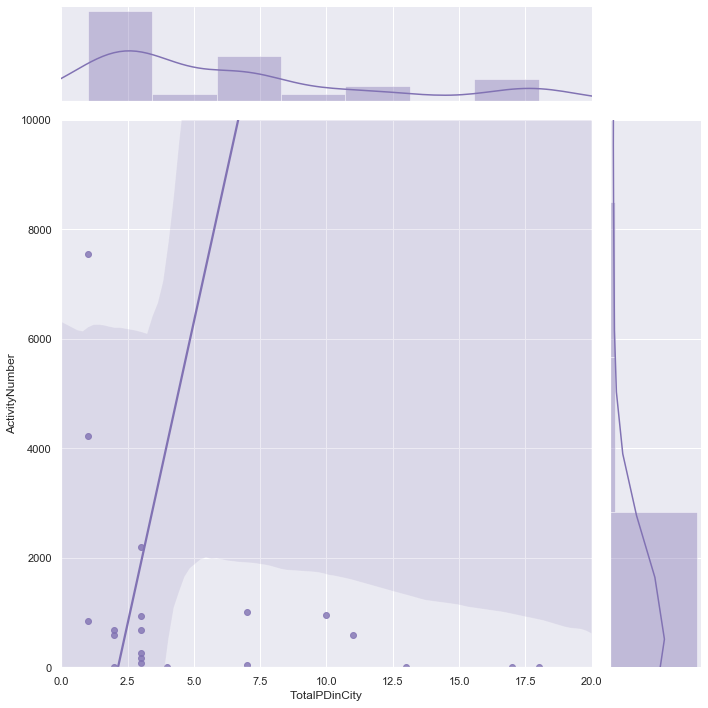

In [16]:
#########################
# This part is optional #
# pip install seaborn 
# before running below
# first fig shows the linear regression model on (x=TotalPoliceDept,y=CrimeActivites)
import seaborn as sns
sns.set(style="darkgrid")
police_df
jointPlot = sns.jointplot(x="TotalPDinCity", y="ActivityNumber", data=police_df, 
              kind="reg", truncate=False, xlim=(0, 20), 
              ylim=(0, 10000), color="m", height=10)
fig2 = jointPlot.fig
fig2.savefig('regression.png')

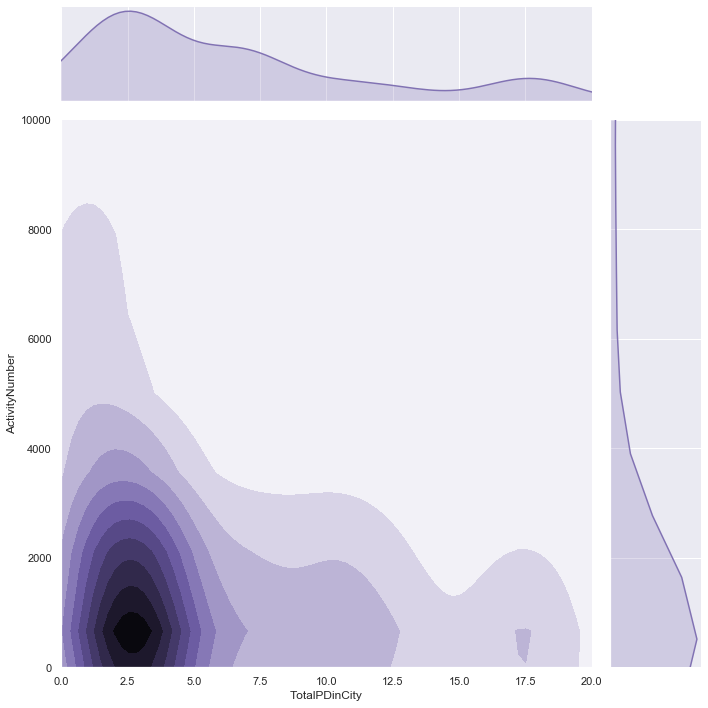

In [17]:
# 2nd fig shows the Kernal Density on (x=TotalPoliceDept,y=CrimeActivites)
jointPlot = sns.jointplot(x="TotalPDinCity", y="ActivityNumber", data=police_df, kind="kde",truncate=False, xlim=(0, 20), 
              ylim=(0, 10000), color="m", height=10)
fig3 = jointPlot.fig
fig3.savefig('density.png')

In [ ]:
#######################################################################
#Conclusion for crime activity on heat map with near by police station
#
#- Initially we thought it would make sense for a city with high crime rate to have more police stations surrounding it 
#
#- However, after ploting every crime incident occured in Sac county on a heat map along with near by police stations on symbol markers, we observed that they have little or no relationship.(see heatmap.png)
#
#- To further illustrate the lack of correlation between the two factors, namely crime activity and near by police stations, we used Seaborn to apply a scattered line regression plot and found a very weak corrlation.(see regression.png)
#
#- Using the same two factors on a Kernal Density plot suggests that a typical city would have between 2-3 police stations regardless of the amount of crime happened in the city.(see density.png)
#

In [21]:
import scipy.stats as st
from scipy.stats import linregress

x_values = police_df['TotalPDinCity']
y_values = police_df['ActivityNumber']

correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
print(f"slope = {slope}")
print(f"intercept = {intercept}")
print(f"rvalue = {rvalue}")
print(f"pvalue = {pvalue}")
print(f"stderr = {stderr}")
print(f"r2value = {rvalue*rvalue}")

The correlation between both factors is 0.44
slope = 2206.797406712039
intercept = -4717.031506688569
rvalue = 0.436600165216763
pvalue = 0.029103551324803238
stderr = 948.1803807282886
r2value = 0.19061970426730473
